## Import needed libraries

In [1]:
import numpy as np
import pathlib, os, random
from tqdm import tqdm
from datetime import datetime
from tqdm.notebook import tqdm
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import albumentations as A

from PraNet.lib.PraNet_ResNeSt import Net
from PraNet.utils.utils import clip_gradient, adjust_lr, AvgMeter

In [2]:
import torch
import torch.nn.functional as F
import torch.utils.data as D
import torchvision.transforms as T
from torch.autograd import Variable

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check GPU
print(DEVICE)

cuda


In [3]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

## Hyperparameters Config

In [4]:
class Config:

    WINDOW = 512

    EPOCHS = 50  # epoch number

    LR = 0.001  # learning rate

    WEIGHT_DECAY = 0.005  # weight decay

    BATCH_SIZE = 4 # training batch size

    CLIP = 0.5  # gradient clipping margin

    DECAY_RATE = 0.1  # decay rate of learning rate

    DECAY_EPOCH = 10  # every n epochs decay learning rate

    TRAIN_DATA_PATH = 'dataset/polyp-dataset/train'  # path to train dataset

    VAL_DATA_PATH = 'dataset/polyp-dataset/val'  # path to val dataset

    TEST_DATA_PATH = 'dataset/polyp-dataset/test'  # path to test dataset

    OUTPUT_PATH = 'Kvasir-output'  # path to output model

config = Config()

## Load Dataset


In [5]:
class Dataset(D.Dataset):

    def __init__(self, root_dir, transform, train='images', mask='masks'):
        self.path = pathlib.Path(root_dir)
        self.train_dir = train
        self.mask_dir = mask
        self.images = []
        self.masks = []
        self.transform = transform
        self.as_Tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
        ])
        self.load_image()

    def load_image(self):
        for i, filename in enumerate(tqdm(os.listdir(os.path.join(self.path, self.train_dir)))):
            img = cv2.imread((self.path / self.train_dir / filename).as_posix())
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (512, 512), cv2.INTER_CUBIC)
            msk = cv2.imread((self.path / self.mask_dir / filename).as_posix())
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
            msk = cv2.resize(msk, (512, 512), cv2.INTER_LINEAR)
            msk = cv2.morphologyEx(msk, cv2.MORPH_CLOSE, kernel=np.ones((5, 5),np.uint8))
            msk = cv2.medianBlur(msk, ksize=5)
            msk = np.clip(msk / 255, 0, 1).astype(np.uint8)

            self.images.append(img)
            self.masks.append(msk)

    def __getitem__(self, index):
        img, msk = self.images[index], self.masks[index]
        augments = self.transform(image=img, mask=msk)
        return self.as_Tensor(augments['image']), augments['mask'][None]

    def __len__(self):
        return len(self.images)

In [6]:
# Define
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
])

In [7]:
train_dataset = Dataset(config.TRAIN_DATA_PATH, transform=transform)
print('Train data size: {}'.format(len(train_dataset)))
val_dataset = Dataset(config.VAL_DATA_PATH, transform=transform)
print('Validation data size: {}'.format(len(val_dataset)))
test_dataset = Dataset(config.TEST_DATA_PATH, transform=transform)
print('Test data size: {}'.format(len(test_dataset)))

  0%|          | 0/1288 [00:00<?, ?it/s]

Train data size: 1288
Validation data size: 162
Test data size: 162


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

In [8]:
train_loader = D.DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = D.DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = D.DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


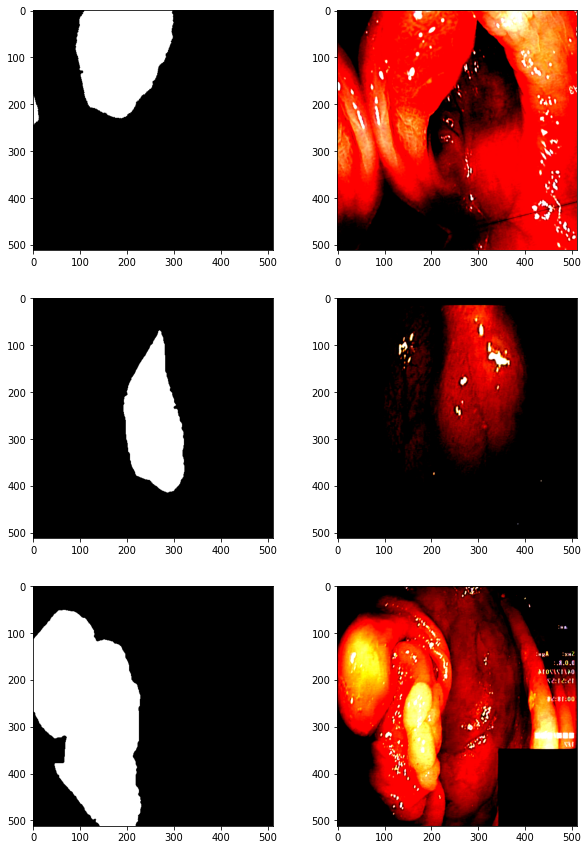

In [9]:
# Show the first train image, validation image and test image
train_img, train_msk = train_dataset[0]
val_img, val_msk = val_dataset[0]
test_img, test_msk = test_dataset[0]
plt.figure(figsize=(10, 15))
plt.subplot(321)
plt.imshow(train_msk[0], cmap='gray')
plt.subplot(322)
plt.imshow(train_img.transpose(0, 2).transpose(0, 1))
plt.subplot(323)
plt.imshow(val_msk[0], cmap='gray')
plt.subplot(324)
plt.imshow(val_img.transpose(0, 2).transpose(0, 1))
plt.subplot(325)
plt.imshow(test_msk[0], cmap='gray')
plt.subplot(326)
plt.imshow(test_img.transpose(0, 2).transpose(0, 1))
plt.show()

## Defince Train and loss

In [10]:
def loss_fn(pred, mask):
    mask = mask.type_as(pred)
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1)/(union - inter+1)
    return (wbce + wiou).mean()

In [11]:
def train(train_loader, val_loader, model, optimizer, epoch, best_val_loss):
    model.train()
    # --- multi-scale training ---
    size_rates = [0.75, 1, 1.25]
    loss_record1, loss_record2, loss_record3, loss_record4 = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()
    val_loss_record1, val_loss_record2, val_loss_record3, val_loss_record4 = AvgMeter(), AvgMeter(), AvgMeter(), AvgMeter()
    tbar = tqdm(train_loader, desc='\r')
    for i, pack in enumerate(tbar, start=1):
        for rate in size_rates:
            optimizer.zero_grad()
            # --- data prepare ---
            images, gts = pack
            images = images.cuda()
            gts = gts.float().cuda()
            # --- rescale ---
            trainsize = int(round(config.WINDOW * rate / 32) * 32)
            if rate != 1:
                images = F.upsample(images, size=(trainsize, trainsize), mode='bilinear', align_corners=True)
                gts = F.upsample(gts, size=(trainsize, trainsize), mode='bilinear', align_corners=True)
            # --- forward ---
            out_4, out_3, out_2, out_1 = model(images)
            # --- loss function ---
            loss_4 = loss_fn(out_4, gts)
            loss_3 = loss_fn(out_3, gts)
            loss_2 = loss_fn(out_2, gts)
            loss_1 = loss_fn(out_1, gts)
            loss = 0.8 * loss_4 + 0.8 * loss_3 + 0.8 * loss_2 + 1.6 * loss_1
            # --- backward ---
            loss.backward()
            clip_gradient(optimizer, config.CLIP)
            optimizer.step()
            # --- recording loss ---
            if rate == 1:
                loss_record1.update(loss_1.data, config.BATCH_SIZE)
                loss_record2.update(loss_2.data, config.BATCH_SIZE)
                loss_record3.update(loss_3.data, config.BATCH_SIZE)
                loss_record4.update(loss_4.data, config.BATCH_SIZE)
        # --- train visualization ---
        tbar.set_description("{} Epoch [{}/{}, out-1: {}, out-2: {}, out-3: {}, out-4: {}"
                             .format(datetime.now(), epoch, config.EPOCHS, loss_record1.show(), loss_record2.show(),
                                     loss_record3.show(), loss_record4.show()))
    with torch.no_grad():
        tbar = tqdm(val_loader, desc='\r')
        for i, val_pack in enumerate(tbar, start=1):
            # --- data prepare ---
            val_images, val_gts = val_pack
            val_images = Variable(val_images).cuda()
            val_gts = Variable(val_gts).cuda()

            # --- Validation ---
            val_out_4, val_out_3, val_out_2, val_out_1 = model(val_images)
            val_loss_4 = loss_fn(val_out_4, val_gts)
            val_loss_3 = loss_fn(val_out_3, val_gts)
            val_loss_2 = loss_fn(val_out_2, val_gts)
            val_loss_1 = loss_fn(val_out_1, val_gts)

            # --- recording loss
            val_loss_record4.update(val_loss_4.data, config.BATCH_SIZE)
            val_loss_record3.update(val_loss_3.data, config.BATCH_SIZE)
            val_loss_record2.update(val_loss_2.data, config.BATCH_SIZE)
            val_loss_record1.update(val_loss_1.data, config.BATCH_SIZE)

            tbar.set_description('{} Epoch [{}/{}], val-out-1: {}, val-out-2: {}, val-out-3: {}, val-out-4: {}'
                                 .format(datetime.now(), epoch, config.EPOCHS, val_loss_record1.show(), val_loss_record2.show(),
                                         val_loss_record3.show(), val_loss_record4.show()))

        current_val_loss = val_loss_record1.show()
        if current_val_loss < best_val_loss[-1]:
            best_val_loss.append(current_val_loss)
            save_path = config.OUTPUT_PATH
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_path, 'model-best.pth'))
            print('Current Best Val Loss for output 1: {}, Saving Snapshot: {}'.format(best_val_loss[-1], os.path.join(save_path, 'model-best.pth')))

## Build Model

In [12]:
# torch.cuda.set_device(0)  # Set your gpu device
# model = PraNet().cuda()  # Load model
model = Net().cuda()

In [13]:
params = model.parameters()  # model parameters
optimizer = torch.optim.AdamW(params, lr=config.LR, weight_decay=config.WEIGHT_DECAY)
# optimizer = torch.optim.SGD(params, lr=config.LR, weight_decay=config.WEIGHT_DECAY, momentum=0.9)

In [ ]:
best_val_loss = [10]
for epoch in range(1, config.EPOCHS+1):
    adjust_lr(optimizer, config.LR, epoch, config.DECAY_RATE, config.DECAY_EPOCH)
    train(train_loader, val_loader, model, optimizer, epoch, best_val_loss)

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

Current Best Val Loss for output 1: 0.9613648653030396, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.8889021277427673, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.8888002634048462, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.7138301730155945, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.652768611907959, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.6229538321495056, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.5324435830116272, Saving Snapshot: Kvasir-output/model-best.pth
Current Best Val Loss for output 1: 0.5119624137878418, Saving Snapshot: Kvasir-output/model-best.pth


:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

:   0%|          | 0/41 [00:00<?, ?it/s]

:   0%|          | 0/322 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load('Kvasir-output/model-best.pth'))
model = model.eval()

In [ ]:
# Randomly inference on one image
random_index = random.randint(0, len(val_dataset)+1)
img, gt = val_dataset[random_index]
img = img[None]
gt = gt
with torch.no_grad():
    _, _, _, pred = model(img.cuda())
    result = pred[0].sigmoid().cpu().numpy()[0]
    result[result >= 0.6] = 1
    result[result < 0.6] = 0
    result.astype(np.uint8)

    plt.figure(figsize=(16, 12))
    plt.subplot(131)
    plt.imshow(result, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt[0], cmap='gray')
    plt.subplot(133)
    plt.imshow(img[0].transpose(0, 2).transpose(0, 1))
    plt.show()

In [ ]:
def iou(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    tp = sum(pred * mask)
    fp_fn = sum(pred != mask)
    iou = tp / (tp + fp_fn)
    return iou

def mae(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    abs_error = np.abs(pred - mask)
    mae = np.mean(abs_error)
    return mae

def dice(pred, mask):
    pred, mask = pred.flatten(), mask.flatten()
    intersection = sum(pred * mask)
    dice = (intersection * 2) / (np.sum(mask) + np.sum(pred))
    return dice

In [ ]:
# Calculate Metrics
Miou, Amae, Mdice = [], [], []
with torch.no_grad():
    tbar = tqdm(val_dataset, desc='\r', ascii=True)
    for pack in tbar:
        img, gt = pack
        img = img[None]
        _, _, _, pred = model(img.cuda())
        result = pred[0].sigmoid().cpu().numpy()[0]
        result[result > 0.6] = 1
        result[result <= 0.6] = 0
        result.astype(np.uint8)

        Miou.append(iou(result, gt[0]))
        Amae.append(mae(result, gt[0]))
        Mdice.append(dice(result, gt[0]))

        tbar.set_description('Mean IOU: {:.4f}, Average MAE: {:.4f}, Mean DICE: {:.4f}'
                             .format(np.mean(Miou), np.mean(Amae), np.mean(Mdice)))